In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from sklearn.metrics import f1_score

In [22]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [23]:
# Normal dataset
#df = pd.read_csv('CSVFiles/smallDomainDataBertweetEmbedded.csv')
df = pd.read_csv('CSVFiles/small10000DomainDataBertweetEmbedded.csv')
#df = pd.read_csv('CSVFiles/small50000DomainDataBertweetEmbedded.csv')
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

In [24]:
# Updating values for training_data
training_data = df[df['split'] == 'train']

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']

In [25]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples validation data: ', sum(validation_data['toxicity']))
print('None-toxic samples validation data: ', len(validation_data['toxicity'])-sum(validation_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  3510.0
None-toxic samples training data:  3510.0


Toxic samples validation data:  710.0
None-toxic samples validation data:  710.0


Toxic samples test data:  710.0
None-toxic samples test data:  710.0


male: 1645.0
female: 1450.0
LGBTQ: 1153.0
christian: 1048.0
muslim: 1167.0
other_religion: 20.0
black: 1265.0
white: 1842.0


In [26]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

In [27]:
### Set parameters for the model
#torch.manual_seed(2) # set fixed random seed for reproducibility

cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [18]:
# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())

prepare_trainloader = []
for i in range(len(X_train)):
    prepare_trainloader.append([X_train[i], Y_train[i]])
    
prepare_testloader = []
for i in range(len(X_test)):
    prepare_testloader.append([X_test[i], Y_test[i]])
    
prepare_validloader = []
for i in range(len(X_val)):
    prepare_validloader.append([X_val[i], Y_val[i]])

NameError: name 'training_data' is not defined

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(768, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [14]:
def Train(model, train_loader, valid_loader, loss_function, optimizer, learning_rate, early_stopping=50, epochs=1000):
    # Setting up model parameters
    
    model = model.to(device)
    
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    if optimizer == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    loss_function = loss_function

    # Initialising early stopping criterias
    early_stopping = early_stopping
    notImproved = 0
    
    bestLoss = None
    bestModel = None

    trainArr = []
    valArr = []

    bestf1 = 0
    bestEpoch = 0

    for epoch in range(1, epochs + 1):
    
        train_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
        
            # get the input
            inputs, labels = data
    
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
        
            optimizer.zero_grad()
        
            outputs = model(inputs)
            outputs = outputs.squeeze(1)
        
            loss = loss_function(outputs, labels)
        
            loss.backward()
        
            optimizer.step()
        
            train_loss += loss.item()
    
        train_loss /= len(train_loader.dataset)    
        trainArr.append(train_loss)
    
        valid_loss = 0
        labs = []
        preds = []
        
        model.eval()
        with torch.no_grad():        
            for batch_idx, data in enumerate(valid_loader):
                # get the input
                inputs, labels = data           
            
                inputs = inputs.to(device).float()
                labels = labels.to(device).float()
                
                outputs = model(inputs).squeeze()
                
                labs.extend(labels)
                preds.extend(torch.round(outputs))
            
                valid_loss += loss_function(outputs, labels).item()
        
        valid_loss /= len(valid_loader.dataset)    
        valArr.append(valid_loss)
        
        if bestLoss == None:
            bestLoss = valid_loss
    
        if valid_loss <= bestLoss:
            bestModel = torch.save(model, 'currentModel.pth')
            bestLoss = valid_loss
            notImproved = 0
            bestEpoch = epoch
        else:
            notImproved +=1
        
        if notImproved >= early_stopping:
            break

    model = torch.load('currentModel.pth')
    return model, valArr, trainArr, epoch

In [15]:
learning_rates = [0.001, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001]
loss_functions = [nn.BCELoss(), nn.MSELoss()]
optimizers = ['AdamW', 'Adam']
batch_sizes = [4, 8, 16, 32, 64]

valArr = None
trainArr = None
bestLoss = None
bestAcc = 0

with open('GridSearchResults', 'w') as f:
    f.write('epoch, learning rate, loss_function, optimizer, batch_size, Val accuracy, Test accuracy')
    f.write('\n')
    f.close()
    
    for lr in learning_rates:
        for loss_function in loss_functions:
            for optimizer in optimizers:
                for batch_size in batch_sizes:

                    # Creating loaders
                    train_loader = torch.utils.data.DataLoader(prepare_trainloader, batch_size=batch_size, shuffle=True)
                    valid_loader = torch.utils.data.DataLoader(prepare_validloader, batch_size=batch_size, shuffle=False)
                    test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=batch_size, shuffle=False)               

                    model, valLossArr , trainLossArr, epoch = Train(Net(), train_loader,
                                                                 valid_loader, loss_function,
                                                                 optimizer, lr, early_stopping=50, epochs=5000)

                    labs = []
                    preds = []
                    model.eval()
                    with torch.no_grad():        
                        for batch_idx, data in enumerate(valid_loader):
                            inputs, labels = data
                            inputs = inputs.to(device).float()
                            labels = labels.to(device).float()
                            outputs = model(inputs).squeeze()
                            labs.extend(labels)
                            preds.extend(torch.round(outputs))
                    accVal = CheckAccuracy(labs, preds)
                    #print("Accuracy on validation set: ", accVal)

                    labs = []
                    preds = []
                    model.eval()
                    with torch.no_grad():        
                        for batch_idx, data in enumerate(test_loader):
                            inputs, labels = data
                            inputs = inputs.to(device).float()
                            labels = labels.to(device).float()
                            outputs = model(inputs).squeeze()
                            labs.extend(labels)
                            preds.extend(torch.round(outputs))
                    accTest = CheckAccuracy(labs, preds)
                    #print("Accuracy on Test set: ", accTest)

                    currModelValLoss = np.min(valLossArr)    
                    if bestLoss == None:
                        bestLoss = currModelValLoss

                    if accVal > bestAcc:
                        bestAcc = accVal
                        bestLoss = currModelValLoss
                        valArr = valLossArr
                        trainArr = trainLossArr

                    elif accVal >= bestAcc and currModelValLoss < bestLoss:
                        bestAcc = accVal
                        bestLoss = currModelValLoss
                        valArr = valLossArr
                        trainArr = trainLossArr
                    
                    with open('GridSearchResults', 'a') as f:
                        print(str(epoch)+","+str(lr)+","+ str(loss_function) + "," + optimizer + "," + str(batch_size) + "," + str(accVal) + "," + str(accTest))
                        f.write(str(epoch)+","+str(lr)+","+ str(loss_function) + "," + optimizer + "," + str(batch_size) + "," + str(accVal) + "," + str(accTest))
                        f.write('\n')
                        f.close()

58,0.001,BCELoss(),AdamW,4,0.5791666666666667,0.5944444444444444
56,0.001,BCELoss(),AdamW,8,0.5777777777777777,0.6208333333333333
57,0.001,BCELoss(),AdamW,16,0.5694444444444444,0.5958333333333333
61,0.001,BCELoss(),AdamW,32,0.5694444444444444,0.5916666666666667
64,0.001,BCELoss(),AdamW,64,0.5708333333333333,0.5958333333333333
73,0.001,BCELoss(),Adam,4,0.5847222222222223,0.6152777777777778
58,0.001,BCELoss(),Adam,8,0.5763888888888888,0.6166666666666667
55,0.001,BCELoss(),Adam,16,0.5888888888888889,0.5861111111111111
57,0.001,BCELoss(),Adam,32,0.5652777777777778,0.5819444444444445
58,0.001,BCELoss(),Adam,64,0.5486111111111112,0.5708333333333333
59,0.001,MSELoss(),AdamW,4,0.5791666666666667,0.6041666666666666
57,0.001,MSELoss(),AdamW,8,0.5819444444444445,0.6097222222222223
56,0.001,MSELoss(),AdamW,16,0.5791666666666667,0.6166666666666667
60,0.001,MSELoss(),AdamW,32,0.5708333333333333,0.5944444444444444
65,0.001,MSELoss(),AdamW,64,0.5736111111111111,0.6194444444444445
57,0.001,MSELoss(),Ad

In [20]:
# Finding the best model from the generated csv file
results = pd.read_csv('GridSearchResultsFinal')

results.loc[np.argmax(results['Val accuracy'])]

epoch                 2979
learning rate        1e-06
loss_function    MSELoss()
optimizer            AdamW
batch_size              32
Val accuracy           0.6
Test accuracy     0.608333
Name: 113, dtype: object

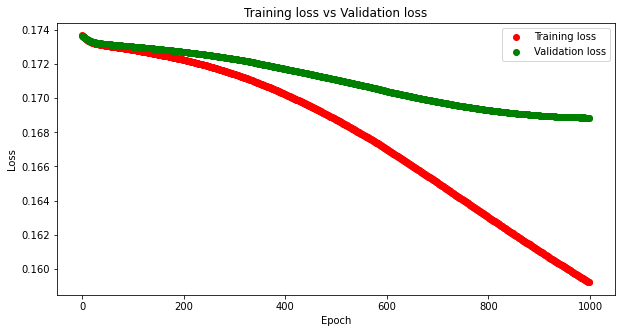

In [37]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r', label='Training loss')
plt.scatter(np.arange(0,len(valArr)), valArr, color='g', label='Validation loss')
plt.title("Training loss vs Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [36]:
def F1_Scores(preds, labels):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i in range(len(labs)):
        if labels[i]==1 and preds[i]==1:
            true_positives += 1
        if labels[i]==0 and preds[i]==0:
            true_negatives += 1
        if labels[i]==0 and preds[i]==1:
            false_positives += 1
        if labels[i]==1 and preds[i]==0:
            false_negatives += 1
    print("true_positives", true_positives)
    print("true_negatives", true_negatives)
    print("false_positives", false_positives)
    print("false_negatives", false_negatives)
    
    return true_positives, true_negatives, false_positives, false_negatives

In [37]:
labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(test_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on test set: ", CheckAccuracy(labs, preds))
#f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
#print("F1_score test: ", f1)
#true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(valid_loader):
        # get the input
        inputs, labels = data
        
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on validation set: ", CheckAccuracy(labs, preds))
#f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
#print("F1_score val: ", f1)
#true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(train_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on train set: ", CheckAccuracy(labs, preds))
#f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
#print("F1_score train: ", f1)
#true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)


Accuracy on test set:  0.6138888888888889
Accuracy on validation set:  0.5805555555555556
Accuracy on train set:  0.643661971830986
